# Crystal Size Distribution for a cooling liquid

This notebook is a first attempt to model the evolution of the crystal size
distribution (CSD) as a function of time as a packet of liquid cools through
its melting temperature. The general idea is based on Spillar and Dolejs (2013;
Journal of Petrology 54:913-931) but instead of attempting to invert a measured
CSD to find cooling history we will impose a cooling history and calculate the
resulting CSD. Another paper worth reading is Marsh (1998; Journal of Petrology 
39:553-599), which sets up much of the background.

The CSD, $n(L, t)$ describes the number density of crystals of radius $L$ in a
volume of liquid at time $t$. Its evolution with time depends on a balance of 
the nucleation rate, $I$, and the crystal growth rate, $G$. Both of these are 
functions that are equal to zero at the melting temperature, $T_m$, and which
increase with undercolling. For almost all igneous rocks all the melt has
crystalised and this imposes geometic  constraints that modifies the
behaviour of $I$ and $G$. But we are interested in low crystallinity, so
we will assume that $I$ and $G$ are only controlled by the thermodynamic 
and kintetic effects.

I will use some data for Cu, because this seems to be hanging around, assume
growth rate is linear, and take a simple form for G (really we should use
equation 5 from Davies et al. 2019; EPSL 507:1-9, but that has too many terms for
me today).


In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Data for Cu (because I have a EAM set up in LAMMPS for Cu in case we want to take it further)

kB = 1.380649e-23 # J/K
cu_k0 = 212 * 1E-4 # [K^-1]? Table 2 # and made 1000 times smaller
cu_tm = 1275 # [K] Table 1
cu_dhm = 1.21 * kB * cu_tm # [J] SI table S1, heat of fusion at melting point
g_factor = 2E6 # A constant for the nucleation rate.

In [3]:
def growth_rate(t, tm, dhm, k0):
    """
    Linear growth rate - see Sun et al. Nat Materials paper
    t is the temperature
    Tm is the melting temperature
    dmu is the difference in chekical potentials
    k0 is a rate constant
    r is the particle radius
    """
    d_mu = (tm - t) * (dhm / tm) # K13 / first para of Sun SI
    kB = 1.380649e-23 #J/K
    v = k0 * (1.0 - np.exp(-d_mu/(kB * t)))
    return v


In [4]:
def nucleation_rate(t, tm, dhm, surf_e):
    """
    Simple nucleation rate. Just say it goes with the square of the undercooling...
    ... need to do better
    t is the temperature
    Tm is the melting temperature
    dmu is the difference in chekical potentials
    k0 is a rate constant
    r is the particle radius
    """
    d_mu = (tm - t)**2 * (dhm / tm) # K13 / first para of Sun SI
    kB = 1.380649e-23 #J/K
    g = surf_e * (1.0 - np.exp(-d_mu/(kB * t)))
    return g

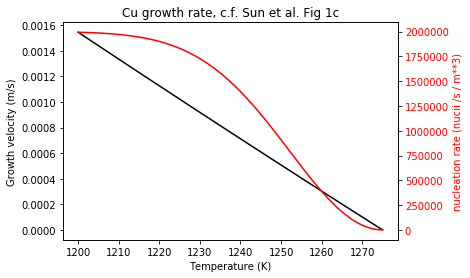

In [5]:
fig, ax = plt.subplots()
ts = np.linspace(1200, cu_tm)
vs = growth_rate(ts, cu_tm, cu_dhm, cu_k0)
gs = nucleation_rate(ts, cu_tm, cu_dhm, g_factor)
ax.plot(ts, vs, 'k')
ax2 = ax.twinx()
ax2.plot(ts, gs, 'r')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Growth velocity (m/s)')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('nucleation rate (nucii /s / m**3)', color='r')
ax.set_title('Cu growth rate, c.f. Sun et al. Fig 1c')
plt.show()

We need some temperature history for our melt packet. Linear cooling for now.
We will run to 1200 K. So set up some empty arrays.

In [6]:
initial_temperature = 1275.0 #  below tm!
cooling_rate = 0.1 # K/s
end_temperature = 1265 # K
# Volume is 1 m**3
max_time = (initial_temperature - end_temperature) / cooling_rate
print("Run time will be", max_time, "seconds")
time_step = 0.005 # s
n_steps = int(max_time / time_step)
print("Will run for", n_steps, "steps")
times = np.arange(0, max_time, time_step)

# We could integrate G to get Lmax (see S&D18) but let's just set up a fixed
# grid for the CSD
l_max = 0.1 # m
delta_l = 0.000001 # m
n_l = int(l_max / delta_l) +1 # Why sometimes +1?
print("Will have", n_l, "size bins in the csd")
sizes = np.arange(0, l_max, delta_l)
csd = np.zeros((n_steps, n_l), dtype='int')
print("csd array shape and size:", csd.shape, csd.size)

Run time will be 100.0 seconds
Will run for 20000 steps
Will have 100001 size bins in the csd
csd array shape and size: (20000, 100001) 2000020000


In [7]:
start_time = time.time()
temperature = initial_temperature
csd[0, :] = 0 # Initial condition
for ii, t in enumerate(times[1:]):
    i = ii + 1 # To deal with enumerate starting from 0.
    # Grow the CSD
    v = growth_rate(temperature, cu_tm, cu_dhm, cu_k0)
    # Assume v is positive (growth)
    # and move from large to small growing crystals.
    # Move CSD from cell j in time t-1 to j+delta_j at time t 
    delta_j = int((v * time_step) / delta_l)
    if delta_j <= 0:
        # Just push csd to next timestep
        #print("Timestep", i, "no change in CSD")
        csd[i,:] = csd[i-1,:]
        #print("Instant CSD sample:", csd[i, ::100])
    else:
        for j in range(n_l):
            if j + delta_j <= n_l-1:
                #print("j", j, "moving to ", j + delta_j)
                csd[i, j + delta_j] = csd[i-1, j]
            else:
                #print("j", j, "moving to end")
                csd[i, n_l-1] = csd[i-1, j] + csd[i, n_l-1]
        #print("Instant CSD sample:", csd[i, :])       
        #break
    # Nucleation (always at L=0, i.e assume nuclii are small)
    g = nucleation_rate(temperature, cu_tm, cu_dhm, g_factor) 
    csd[i,0] = csd[i,0] + int(g * time_step) # Assume 1 m**3 box
    crystalinity = np.sum((4/3) * np.pi * (csd[i,:] * (sizes+(0.5*delta_l))**3)) / 1.0
    if crystalinity >= 1.0:
        print("Frozen!")
        break
    if i%10000 == 0:
        print("\nStep:", i, "time:", t)
        print("temperature:", temperature, "g:", g, "v", v)
        print("delta_j", delta_j)
        print("v*dt", v * time_step)
        print("New partcles this step", int(g * time_step))
        print("Max size particles this step", csd[i,-1])
        print("Total particles:", np.sum(csd[i,:]))
        print("Instant CSD sample (every 1000th bin):", csd[i,::1000])
        print("Instant crystalinity:", crystalinity)
        print("Wall time per timestep:", (time.time() - start_time) / i)
    temperature = temperature - (cooling_rate*time_step)

print("Done")


Step: 10000 time: 50.0
temperature: 1270.0004999989815 g: 47065.61201305148 v 0.00010074186463154811
delta_j 0
v*dt 5.037093231577406e-07
New partcles this step 235
Max size particles this step 0
Total particles: 782564
Instant CSD sample (every 1000th bin): [782564      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0]
Instant crystalinity:

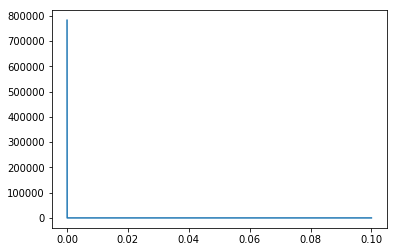

In [8]:
fig, ax = plt.subplots()
ax.plot(sizes, csd[10000,:])
plt.show()

# Plot the whole CSD over time: clearly not a good idea
#fig, ax = plt.subplots()
#cols = ax.imshow(np.log(csd[:,950:]+1).T, aspect='auto', interpolation='none', origin='lower', cmap='gray_r')
#fig.colorbar(cols)
#plt.show()